In [1]:
#Import the necessary modules 
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime
from keras.layers import Embedding
from keras.models import load_model

Using TensorFlow backend.


In [33]:
# Tolerance Limit for computing the accuracy
tolerance_limit = 5
# Device count for determining the number of devices to extract the data 
deviceCount = 4
# Metric count for determining the count of the metric to perform the model computations 
metricCount = 2
# Device Ids to extract the data 
device_ids = ['2421540','1640315','1833973','1478336']

In [3]:
#Read the csv file as the input 
df = pandas.read_csv('combined0917-1001.csv', engine='python')
# Delete the unknown columns
del df['unknown']
# Get the metric name column from the pandas dataframe 
df['metric_name'] = pandas.Categorical(df.metric_name)

In [4]:
# Get all the rows whose metric name is utilization 
df = df[df['metric_name']=='utilization']
# Convert the time from the linux epoch time to date time format 
df['poller_time']=df['poller_time'].apply(lambda x :datetime.datetime.fromtimestamp(x).strftime('%c'))

In [34]:
# Define a dictionary with all the metric names to defined 
data = {'poller_time':[],'metric_name':[]} 
# Add the devices to the dictionaries 
for device in device_ids:
    data[device] = []

In [6]:
# Createa a data frame from the created dictionary
df1 = pandas.DataFrame(data) 

row_count = 0
col = 0

# ITterate over the rows in the existing dataframe by getting the metrics for a device count
for row in range(0,df.count()[0],deviceCount):
    new_row = []
    new_row.append(df.iloc[row,0])
    # Iterate over each device Count 
    for i in range(deviceCount):
        new_row.append(df.iloc[row,2])
        row = row + 1
    new_row.append('utilization')
    # Convert the pandas data frame to a pandas series
    ps = pandas.Series(new_row, index=['poller_time','2421540.0','1640315.0','1833973.0','1478336.0','metric_name'])
    # Append the pandas series to a data frame 
    df1 = df1.append(ps, ignore_index=True)

In [7]:
# Ignore the dataframe indexes 
dataset = df1.values

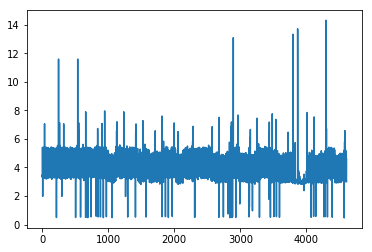

In [8]:
def plotData(dataset):
    """
    Function to plot the data to identify the graph trends 
    : param : dataset - pandas dataframe 
    """
    # Create a list to store the data set for the devices 
    poller_time = []
    device_1 = []
    device_2 = []
    device_3 = []
    device_4 = []
    timeStep = []
    
    # Add the values to a list to display the graph 
    var = 0
    # Iterate over all the rows in the dataset 
    for row in dataset:
        # Var to print the timestep 
        var += 1
        # Append the timestep
        timeStep.append(var)
        # Append the poller time 
        poller_time.append(row[0])
        # Append the corresponding devices 
        device_1.append(row[1])
        device_2.append(row[2])
        device_3.append(row[3])
        device_4.append(row[4])
    # Plot the data 
    plt.figure(1)
    plt.plot(timeStep,device_1)
    plt.show()

# Invoke the function
plotData(dataset)


In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.99)

# Determine the testsize 
test_size = len(dataset) - train_size

# Obtain the train and the test size 
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4561 47


In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    """
    Function to create a dataset based on the look back 
    :dataset - Input dataset with the necessary metrics 
    :lookback - how many data points to view back 
    """
    # Create the list to store the input data point and the output labels 
    dataX, dataY = [], []
    # Iterate over the dataset with the lookback 
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        a = a[0][1:-1]
        # Append the input data set 
        dataX.append(a)
        # Append the label 
        dataY.append(dataset[i + look_back][1:-1])
    # Return the numpy array of the result 
    return np.array(dataX, dtype='float'), np.array(dataY)

In [11]:
def split_sequences(sequences, n_steps):
    """
    Function to split the sequences 
    """
    X, y, y_2, y_3 = list(), list(), list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix+2 >= len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, -5:-1], sequences[end_ix, -5:-1]
        # Get the sequence 2 timestep 
        seq_y_time_step_2 = sequences[end_ix+1,-5:-1]
        #Get the sequence 3 timestep 
        seq_y_time_step_3 = sequences[end_ix+2,-5:-1]
        # Append the datasets into the corresponding values 
        X.append(seq_x)
        y.append(seq_y)
        y_2.append(seq_y_time_step_2)
        y_3.append(seq_y_time_step_3)
    # Return the numpy arrays
    return np.array(X), np.array(y), np.array(y_2), np.array(y_3)

In [12]:
# Lookback = 1, hyperparameter to tune for
look_back = 1
# Invoke create dataset function for the train dataset 
trainX, trainY = create_dataset(train, look_back)
# Invoke the create dataset function for the test dataset 
testX, testY = create_dataset(test, look_back)
print(np.shape(trainX))
# Append the train dataset horizontally 
train_up = np.hstack((trainX,trainY))
print(np.shape(train_up))
# Append the test dataset horizontally
test_up = np.hstack((testX,testY))
print(np.shape(test_up))

(4559, 4)
(4559, 8)
(45, 8)


In [13]:
# Invoke the split sequences function on the train dataset 
trainX_updated = split_sequences(train_up,10)
print(np.shape(trainX_updated[0]))
# Invoke the split sequences on the test dataset 
testX_updated = split_sequences(test_up,10)
print(np.shape(testX_updated[0]))
# For the 3 time steps get the train and the test dataset separately 
trainX_data = trainX_updated[0]
trainY_data = trainX_updated[1]
trainY_data_1 = trainX_updated[2]
trainY_data_2 = trainX_updated[3]
testX_data = testX_updated[0]
testY_data = testX_updated[1]
testY_data_1 = testX_updated[2]
testY_data_2 = testX_updated[3]

(4547, 10, 4)
(33, 10, 4)


In [14]:
# Printing the values 
print(testX_data[0])
print(testY_data[0])
print(testY_data_1[0])
print(testY_data_2[0])

[[5.74 3.14 0.54 1.15]
 [5.87 3.09 0.51 5.8]
 [2.52 3.1 0.64 6.02]
 [2.9 5.07 0.57 5.06]
 [1.59 3.4 0.53 4.51]
 [1.21 3.19 0.57 1.43]
 [4.3 3.21 2.0 4.39]
 [1.71 3.17 0.5 1.64]
 [4.77 3.07 0.55 1.69]
 [4.63 5.21 0.51 4.58]]
[1.76 0.47 3.08 4.88]
[1.38 3.18 0.5 4.94]
[1.3 3.15 0.55 1.98]


In [15]:
# create and fit the LSTM network using the Keras library 
model = Sequential()
# Add an LSTM layer with 100 hidden layer LSTMs, activation as Relu , return sequence = True - indicates the addition of another layer 
model.add(LSTM(100, input_shape=(10,4), return_sequences=True, activation='relu'))
# Add an LSTM layer with 100 hidden layer LSTMs, activation as Relu , return sequence = True - indicates the addition of another layer 
model.add(LSTM(100, input_shape=(10,4), return_sequences=True, activation='relu'))
# Add an LSTM layer with 100 hidden layer LSTMs, activation as Relu , the output of which will be passed to a dense fully connected layer 
model.add(LSTM(100, input_shape=(10,4), activation='relu'))
# Add a fully connected layer at the end of the LSTM
model.add(Dense(4))
# Use the MSE loss and adam optimizer 
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(model.summary())
max_eval = 100
count = 0
# Train the model for 150 epochs 
for ep in range(150):
    print("Epoch Number : %s" %count)
    count = count + 1
    # For every epoch fit the train data 
    model.fit(trainX_data, trainY_data, epochs=1,batch_size=32, verbose=2)
    print(model.evaluate(testX_data,testY_data))
    # Determine the test mse 
    eval = model.evaluate(testX_data,testY_data)[0]
    # If the test mse is less than the previous mse
    if(eval < max_eval):
        # Save the model parameters 
        print("Saving Model Parameter")
        model.save('model_params.hd5')
        max_eval = eval

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           42000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 203,204
Trainable params: 203,204
Non-trainable params: 0
_________________________________________________________________
None
Epoch Number : 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 10s - loss: 14.3887 - acc: 0.5722
33/33 [==============================] - 1s 23ms/step
[6.023578932791045, 0.636

33/33 [==============================] - 0s 496us/step
[4.3980963157885, 0.6666666666666666]
33/33 [==============================] - 0s 635us/step
Saving Model Parameter
Epoch Number : 32
Epoch 1/1
 - 5s - loss: 5.5153 - acc: 0.6615
33/33 [==============================] - 0s 743us/step
[4.61929641347943, 0.696969696969697]
33/33 [==============================] - 0s 573us/step
Epoch Number : 33
Epoch 1/1
 - 5s - loss: 5.3711 - acc: 0.6662
33/33 [==============================] - 0s 647us/step
[4.2833833983450225, 0.6666666666666666]
33/33 [==============================] - 0s 544us/step
Saving Model Parameter
Epoch Number : 34
Epoch 1/1
 - 5s - loss: 5.1311 - acc: 0.6754
33/33 [==============================] - 0s 796us/step
[5.587179790843617, 0.6666666666666666]
33/33 [==============================] - 0s 534us/step
Epoch Number : 35
Epoch 1/1
 - 5s - loss: 5.0460 - acc: 0.6664
33/33 [==============================] - 0s 652us/step
[4.674378886367336, 0.696969696969697]
33/33 [====

33/33 [==============================] - 0s 759us/step
[5.841589234092019, 0.5757575757575758]
33/33 [==============================] - 0s 665us/step
Epoch Number : 70
Epoch 1/1
 - 5s - loss: 1.2356 - acc: 0.8282
33/33 [==============================] - 0s 611us/step
[7.083399292646033, 0.6060606060606061]
33/33 [==============================] - 0s 514us/step
Epoch Number : 71
Epoch 1/1
 - 5s - loss: 1.1579 - acc: 0.8337
33/33 [==============================] - 0s 726us/step
[6.734605200362928, 0.5151515151515151]
33/33 [==============================] - 0s 544us/step
Epoch Number : 72
Epoch 1/1
 - 5s - loss: 0.9562 - acc: 0.8410
33/33 [==============================] - 0s 680us/step
[6.625041816270713, 0.6060606060606061]
33/33 [==============================] - 0s 514us/step
Epoch Number : 73
Epoch 1/1
 - 5s - loss: 0.8037 - acc: 0.8603
33/33 [==============================] - 0s 589us/step
[6.8333365872050775, 0.5454545454545454]
33/33 [==============================] - 0s 484us/st

33/33 [==============================] - 0s 635us/step
Epoch Number : 108
Epoch 1/1
 - 5s - loss: 0.5652 - acc: 0.8887
33/33 [==============================] - 0s 815us/step
[6.009852401234887, 0.5757575757575758]
33/33 [==============================] - 0s 544us/step
Epoch Number : 109
Epoch 1/1
 - 5s - loss: 0.3843 - acc: 0.8984
33/33 [==============================] - 0s 646us/step
[6.518656301679033, 0.6363636363636364]
33/33 [==============================] - 0s 514us/step
Epoch Number : 110
Epoch 1/1
 - 5s - loss: 0.3387 - acc: 0.9057
33/33 [==============================] - 0s 654us/step
[6.398965140183766, 0.5757575757575758]
33/33 [==============================] - 0s 514us/step
Epoch Number : 111
Epoch 1/1
 - 6s - loss: 0.2801 - acc: 0.9127
33/33 [==============================] - 0s 642us/step
[6.213475426941207, 0.6060606060606061]
33/33 [==============================] - 0s 695us/step
Epoch Number : 112
Epoch 1/1
 - 5s - loss: 0.2608 - acc: 0.9184
33/33 [==================

 - 5s - loss: 0.2503 - acc: 0.9186
33/33 [==============================] - 0s 753us/step
[6.2564533732154155, 0.6060606060606061]
33/33 [==============================] - 0s 514us/step
Epoch Number : 147
Epoch 1/1
 - 5s - loss: 0.1884 - acc: 0.9283
33/33 [==============================] - 0s 585us/step
[5.910569498033235, 0.6060606060606061]
33/33 [==============================] - 0s 544us/step
Epoch Number : 148
Epoch 1/1
 - 5s - loss: 0.1597 - acc: 0.9309
33/33 [==============================] - 0s 525us/step
[6.148172813834566, 0.6060606060606061]
33/33 [==============================] - 0s 544us/step
Epoch Number : 149
Epoch 1/1
 - 5s - loss: 0.1445 - acc: 0.9342
33/33 [==============================] - 0s 747us/step
[5.989072974884149, 0.6060606060606061]
33/33 [==============================] - 0s 514us/step


In [16]:
print("Loading Model Parameters")
model = load_model('model_params.hd5')
# Evaluvate the model on the test data 
model.evaluate(testX_data,testY_data)

Loading Model Parameters
33/33 [==============================] - 1s 26ms/step


[4.267008030053341, 0.7272727272727273]

[1.1478282 3.497919  0.6922538 3.5811682]
(10, 4)
(33, 10, 4)
[1.1478282 3.497919  0.6922538 3.5811682]
[1.76 0.47 3.08 4.88]
[1.8861604 3.1748958 0.4732443 3.053029 ]
[1.38 3.18 0.5 4.94]
[1.6573372  3.5432281  0.56874406 2.8286085 ]
[1.3 3.15 0.55 1.98]


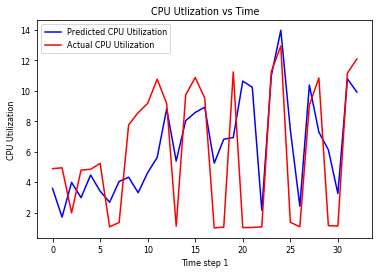

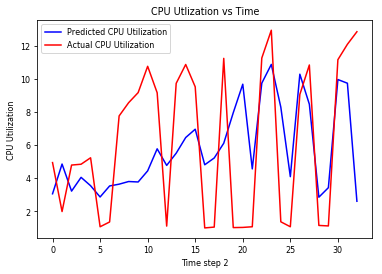

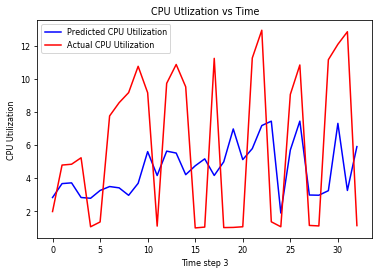

In [17]:
#Update the font size in the matplot lib
plt.rcParams.update({'font.size': 8})
# Predict the output for the test data at time step 1 
output = model.predict(testX_data)
print(output[0])
print(testX_data[0].shape)
# Iterate over the test data 3D tensor
for count in range(len(testX_data)):
    # Stack the output to the test data
    testX_data_temp = np.vstack([testX_data[count],output[count]])
    testX_data[count] = testX_data_temp[1:,:]
print(testX_data.shape)

# Predict the output for the test data at time step 2 
output_1 = model.predict(testX_data)
# Iterate over the test data 3D tensor
for count in range(len(testX_data)):
    # Stack the output to the test data
    testX_data_temp = np.vstack([testX_data[count],output_1[count]])
    testX_data[count] = testX_data_temp[1:,:]
# Predict the output model for the time step 3 
output_2 = model.predict(testX_data)
print(output[0])
print(testY_data[0])
print(output_1[0])
print(testY_data_1[0])
print(output_2[0])
print(testY_data_2[0])

# Define the list to print the data 
timeStep = []
varCount = 0
device_1_out = []
device_1_true_label = []
device_1_out_1 = []
device_1_true_label_1 = []
device_1_out_2 = []
device_1_true_label_2 = []

# Iterate over the predicted output to actual values  
for out in range(output.shape[0]):
    timeStep.append(varCount)
    varCount += 1
    device_1_out.append(output[out,3])
    device_1_true_label.append(testY_data[out,3])
    device_1_out_1.append(output_1[out,3])
    device_1_true_label_1.append(testY_data_1[out,3])
    device_1_out_2.append(output_2[out,3])
    device_1_true_label_2.append(testY_data_2[out,3])
    
# Plot the output using matplot lib 
# Plot the actual and the predicted label 
# Save the figure in the plot.png

plt.figure(1)
plt.plot(timeStep,device_1_out, color = 'blue', label='Predicted CPU Utilization')
plt.plot(timeStep,device_1_true_label, color='red', label='Actual CPU Utilization')
plt.ylabel("CPU Utilization")
plt.xlabel("Time step 1")
plt.title("CPU Utlization vs Time")
plt.legend()
plt.savefig("plot.png")

plt.figure(2)
plt.plot(timeStep,device_1_out_1, color = 'blue', label='Predicted CPU Utilization')
plt.plot(timeStep,device_1_true_label_1, color='red', label='Actual CPU Utilization')
plt.ylabel("CPU Utilization")
plt.xlabel("Time step 2")
plt.title("CPU Utlization vs Time")
plt.legend()
plt.savefig("plot_1.png")

plt.figure(3)
plt.plot(timeStep,device_1_out_2, color = 'blue', label='Predicted CPU Utilization')
plt.plot(timeStep,device_1_true_label_2, color='red', label='Actual CPU Utilization')
plt.ylabel("CPU Utilization")
plt.xlabel("Time step 3")
plt.title("CPU Utlization vs Time")
plt.legend()
plt.savefig("plot_2.png")

plt.show()

In [35]:
# Compute the Accuracy of the model 
mse_list = []
acc_1 = 0
acc_2 = 0
acc_3 = 0

# Iterate over the predicted and the actual values to determing the accuracies
# Accuracy for time step 1
for predicted,actual_values in zip(device_1_out,device_1_true_label):
    if(abs(predicted - actual_values) <= tolerance_limit):
        acc_1 += 1
        
# Accuracy for time step 2 
for predicted,actual_values in zip(device_1_out_1,device_1_true_label_1):
    if(abs(predicted - actual_values) <= tolerance_limit):
        acc_2 += 1 

# Accuracy for time step 3
for predicted,actual_values in zip(device_1_out_2,device_1_true_label_2):
    if(abs(predicted - actual_values) <= tolerance_limit):
        acc_3 += 1 

print("TimeStep 1 Accuracy: %.3f"%(acc_1/len(device_1_out)))
print("TimeStep 2 Accuracy: %.3f"%(acc_2/len(device_1_out_1)))
print("TimeStep 3 Accuracy: %.3f"%(acc_3/len(device_1_out_2)))

TimeStep 1 Accuracy: 0.818
TimeStep 2 Accuracy: 0.788
TimeStep 3 Accuracy: 0.636
